# Predicting What Subreddit a Post Came From
---

### This notebook accomplishes the following:


---

### Prepare data for modeling

Things to do here:
* grab just the subreddit, selftext, and title
* binarize the subreddit column
* train_test_split
* countvectorize the title and selftext

In [6]:
# Imports
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Read in the data files

In [7]:
df1 = pd.read_csv('../data/clean_dmacademy.csv')
df2 = pd.read_csv('../data/clean_truezelda.csv')

In [8]:
frames = [df1, df2]

In [9]:
text_df = pd.concat(frames, axis=0, ignore_index=True)

In [10]:
text_df

,subreddit,title,text
0,DMAcademy,Seeking seasoned DMs to be guests on interview...,Edit UPDATE Thank you for the robust respo...
1,DMAcademy,TERRAIN and Using it Effectively,TERRAIN and using it Effectively DM Tips Usi...
2,DMAcademy,Know the exact location of something,The players are planning on dropping an evil a...
3,DMAcademy,How to run military basic as a session,I am running a campaign for all intents and pu...
4,DMAcademy,Best time to take breaks how long they should be,Hey just a newbie DM My sessions are usually ...
...,...,...,...
8994,truezelda,What happened in the story of the missing link...,I don t really like playing games now but I am...
8995,truezelda,Do you think Blind The Thief is a Sheikah,We know that he lived in Kakariko Village
8996,truezelda,Should games such as Tri Force Heroes and Four...,The Zelda timeline is infamous for being convo...
8997,truezelda,Review score predictions for Skyward HD,Title says it all How will it fare With the o...


In [40]:
text_df.to_csv('../data/dmac_truz.csv', index=False)

In [12]:
text_df.isnull().sum()

subreddit    0
title        0
text         0
dtype: int64

Finally, replace those nulls with empty strings.

---
### Map our target variable to integer values

In [13]:
text_df.dtypes

subreddit    object
title        object
text         object
dtype: object

In [14]:
text_df['subreddit']

0       DMAcademy
1       DMAcademy
2       DMAcademy
3       DMAcademy
4       DMAcademy
          ...    
8994    truezelda
8995    truezelda
8996    truezelda
8997    truezelda
8998    truezelda
Name: subreddit, Length: 8999, dtype: object

In [15]:
# this step is optional
text_df['subreddit'] = text_df['subreddit'].map({'truezelda':1,'DMAcademy':0})

In [16]:
text_df['subreddit']

0       0
1       0
2       0
3       0
4       0
       ..
8994    1
8995    1
8996    1
8997    1
8998    1
Name: subreddit, Length: 8999, dtype: int64

---
### Create X and y

In [17]:
X = text_df['title'] + ' ' + text_df['text']
y = text_df['subreddit']

In [18]:
print(text_df['title'][0])
print(text_df['text'][0][:100])

print(X[0][:150])

Seeking seasoned DMs to be guests on interview podcast
  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hy
Seeking seasoned DMs to be guests on interview podcast   Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I


Looks like it has what we want! 

### Establishing a baseline
In order to measure how good our models are doing, we have to compare our model accuracy to a **baseline**. 

In [19]:
y.value_counts(normalize=True)

0    0.54306
1    0.45694
Name: subreddit, dtype: float64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    stratify = y,
                                                    shuffle=True)

In [21]:
X_train

852     How do I balance NPC Fights Hey Guys I play Pe...
2798    How do I handle starting a campaign adventure ...
7450    What  Stal  enemy could ve also provided bone ...
8383    Zelda songs you just don t like I really like ...
1744    Homebrew Blacksmithing A player in my party is...
                              ...                        
7361    BoTW sequel information what and when  People ...
8212    Skyward Sword Switch port listed on Amazon in ...
7452    Why does anyone consider Ocarina of Time to be...
4498    Campaign Adventure Ideas Some backstory I m cu...
8734    After  years I finally got around to and beati...
Length: 6749, dtype: object

In [22]:
y_train.value_counts(normalize=True)

0    0.543043
1    0.456957
Name: subreddit, dtype: float64

Finally, on to the exciting part - the modeling! 

### Combine GridSearchCV and Bernoulli Naive Bayes model

In [23]:
cvec = CountVectorizer()

In [24]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', BernoulliNB())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', BernoulliNB())])

In [25]:
pipe_params = {
    #'cvec__max_features':[2000, 3000, 4000, 5000],
    #'cvec__min_df':[2, 3],
    #'cvec__max_df':[.9, .95],
    #'cvec__ngram_range':[(1, 1), (1, 2)],
    'nb__alpha':np.logspace(-3, 1, 100)
}

In [26]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [27]:
%time gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

print('train accuracy:', gs.score(X_train, y_train))

print('test accuracy:', gs.score(X_test, y_test))

Wall time: 7min 1s
0.9928882299645828
{'nb__alpha': 0.03430469286314919}
train accuracy: 0.9961475774188768
test accuracy: 0.996


In [ ]:
preds = gs.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

ConfusionMatrixDisplay(cm).plot();

In [ ]:
specificity = tn / (tn + fp)
print('specificity:', specificity)

### TFIDF Vectorizer

In [31]:
tvec = TfidfVectorizer()

In [32]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                         columns = tvec.get_feature_names())

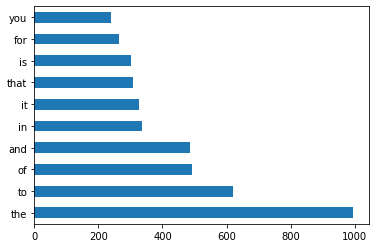

In [33]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

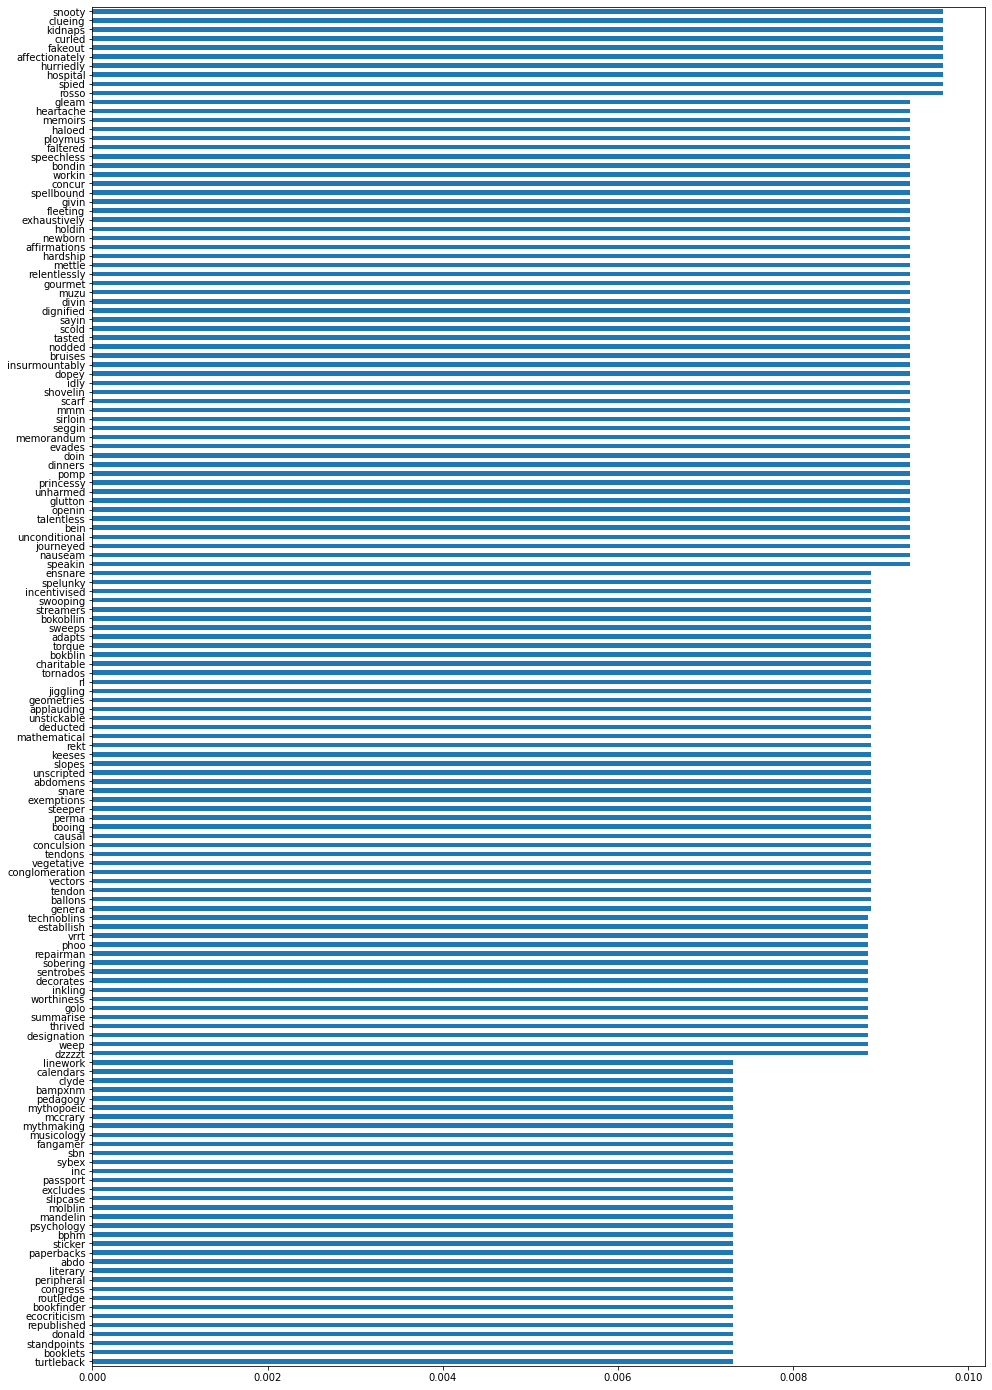

In [34]:
plt.figure(figsize=(16,25))
X_train_df.sum().sort_values(ascending=True).head(150).plot(kind='barh');

In [35]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', BernoulliNB())
])

In [36]:
pipe_tvec_params = {
    #'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha':np.logspace(-3, 1, 100)
}

In [37]:
gs_tvec = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5)

In [38]:
%time gs_tvec.fit(X_train, y_train)

KeyboardInterrupt: 

In [39]:
gs_tvec.score(X_train, y_train)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
gs_tvec.score(X_test, y_test)

In [ ]:
preds_tvec = gs_tvec.predict(X_test)

cm = confusion_matrix(y_test, preds_tvec)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
specificity

In [ ]:
ConfusionMatrixDisplay(cm).plot();

This model is better at classifying true negative, but has greater false negatives! Much higher specificity than the bernoulli naive bayes model.

### Create a Support Vector Machine (SVM) model

In [ ]:
from sklearn.svm import SVC

In [ ]:
# for some reason I can't get SVC to work in a pipeline with cvec
# so I broke it up into two steps

In [ ]:
# cvec = CountVectorizer(stop_words='english')
# X_train = cvec.fit_transform(X_train)
# X_test = cvec.transform(X_test)

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [ ]:
svc=SVC()
pipe_params = {
    #'cvec__max_features':[2000, 3000, 4000, 5000],
    #'cvec__min_df':[2, 3],
    #'cvec__max_df':[.9, .95],
    #'cvec__ngram_range':[(1, 1), (1, 2)],
    #'svc__C': np.linspace(0.0001, 1, 20),
    #'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree':range(2,6),
    #'gamma':['scale', 'auto']
}

In [ ]:
svc_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [ ]:
SVC().get_params().keys()

In [ ]:
# Fit the model on training data

# This takes a few minutes to run so be sure about it! 
%time svc_gs.fit(X_train, y_train)

In [ ]:
print(svc_gs.best_score_)
print('train accuracy:', svc_gs.score(X_train, y_train))
print('test accuracy:', svc_gs.score(X_test, y_test))

In [ ]:
preds = svc_gs.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

In [ ]:
ConfusionMatrixDisplay(cm).plot();

In [ ]:
print(svc_gs.score(X_train, y_train))
print(svc_gs.score(X_test, y_test))

In [ ]:
svc_gs.best_score_

In [ ]:
svc_gs.best_params_

In [ ]:
#X = cvec.transform(X)

In [ ]:
X

In [ ]:
text_df['subreddit']

In [ ]:
results = pd.DataFrame(text_df['subreddit'])

In [ ]:
results.head()

In [ ]:
results['predicted'] = svc_gs.predict(X)

In [ ]:
results.head()

In [ ]:
mask = results['predicted']!=results['subreddit']
row_ids = results[mask].index

In [ ]:
results[mask].index

In [ ]:
print(f'The model guessed this was: {results["predicted"].iloc[38]}.')
print(f'This actually is: {results["subreddit"].iloc[38]}.')

In [ ]:
for index in row_ids[:5]:
    print(text_df['title'].iloc[index])
    print(text_df['selftext'].iloc[index])
    print(f'The model guessed this was: {results["predicted"].iloc[index]}.')
    print(f'This actually is: {results["subreddit"].iloc[index]}.')
    print('\n')
    